In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Coherent Variational Quantum Linear Solver {#coherent_vqls}
==========================================

::: {.meta}
:property=\"og:description\": This demonstration extends the variational
quantum linear solver to solve linear equations defined by a
probabilistic coherent operation. :property=\"og:image\":
<https://pennylane.ai/qml/_images/cvqls_zoom.png>
:::

::: {.related}
tutorial\_vqls Variational Quantum Linear Solver
:::

*Author: Andrea Mari --- 06 November 2019. Last updated: 15 January
2021.*

In this tutorial we propose and implement an algorithm that we call
*coherent variational quantum linear solver* (CVQLS). This is inspired
by the VQLS proposed in Ref. \[1\] (implemented in a
`previous demo <tutorial_vqls>`{.interpreted-text role="doc"}), with an
important difference: the matrix $A$ associated to the problem is
physically applied as a probabilistic coherent operation. This approach
has some advantages and disadvantages and its practical convenience
depends on the specific linear problem to be solved and on experimental
constraints.

![](../demonstrations/coherent_vqls/cvqls_circuit.png){.align-center
width="100.0%"}

Introduction
------------

We first define the problem and the general structure of the CVQLS. As a
second step, we consider a particular case and we solve it explicitly
with PennyLane.

### The problem

We are given a $2^n \times 2^n$ matrix $A$ which can be expressed as a
linear combination of $L$ unitary matrices $A_0, A_1, \dots A_{L-1}$,
i.e.,

$$A = \sum_{l=0}^{L-1} c_l A_l,$$

where $c_l$ are arbitrary complex numbers. Importantly, we assume that
each of the unitary components $A_l$ can be efficiently implemented with
a quantum circuit acting on $n$ qubits.

We are also given a normalized complex vector in the physical form of a
quantum state $|b\rangle$, which can be generated by a unitary operation
$U$ applied to the ground state of $n$ qubits. , i.e.,

$$|b\rangle = U_b |0\rangle,$$

where again we assume that $U_b$ can be efficiently implemented with a
quantum circuit.

The problem that we aim to solve is that of preparing a quantum state
$|x\rangle$, such that $A |x\rangle$ is proportional to $|b\rangle$ or,
equivalently, such that

$$|\Psi\rangle :=  \frac{A |x\rangle}{\sqrt{\langle x |A^\dagger A |x\rangle}} \approx |b\rangle.$$

### Coherent Variational Quantum Linear Solver (CVQLS)

We approximate the solution $|x\rangle$ with a variational quantum
circuit, i.e., a unitary circuit $V$ depending on a finite number of
classical real parameters $w = (w_0, w_1, \dots)$:

$$|x \rangle = V(w) |0\rangle.$$

The parameters should be optimized in order to maximize the overlap
between the quantum states $|\Psi\rangle$ and $|b\rangle$. We define the
following cost function,

$$C = 1- |\langle b | \Psi \rangle|^2,$$

such that its minimization with respect to the variational parameters
should lead towards the problem solution.

The approach used in Ref. \[1\] is to decompose the cost function in
terms of many expectation values associated to the individual components
$A_l$ of the problem matrix $A$. For this reason, in the VQLS of Ref.
\[1\], the state vector proportional to $A |x\rangle$ is not physically
prepared. On the contrary, the idea presented in this tutorial is to
physically implement the linear map $A$ as a coherent probabilistic
operation. This approach allows to prepare the state
$|\Psi\rangle :=  A |x\rangle/\sqrt{\langle x |A^\dagger A |x\rangle}$
which can be used to estimate the cost function of the problem in a more
direct way.

#### Coherently applying $A$

The problem of coherently applying a liner combination of unitary
operations has been already studied in Ref. \[2\] and here we follow a
very similar approach.

Without loss of generality we can assume that the coefficients
$c=(c_1, c_2, \dots c_L)$ appearing in the definition of $A$ represent a
positive and normalized probability distribution, i.e.,

$$c_l \ge 0 \quad \forall l,  \qquad \sum_{l=0}^{L-1} c_l=1.$$

Indeed the complex phase of each coefficient $c_l$ can always be
absorbed into the associated unitary $A_l$, obtaining in this way a
vector of positive values. Moreover, since the linear problem is defined
up to a constant scaling factor, we can also normalize the coefficients
to get a probability distribution.

For simplicity, since we can always pad $c$ with additional zeros, we
assume that $L=2^m$ for some positive integer $m$.

Let us consider a unitary circuit $U_c$, embedding the square root of
$c$ into the quantum state $|\sqrt{c}\rangle$ of $m$ ancillary qubits:

$$|\sqrt{c} \rangle =  U_c |0\rangle = \sum_{l=0}^{L-1} \sqrt{c_l} | l \rangle,$$

where $\{ |l\rangle \}$ is the computational basis of the ancillary
system.

Now, for each component $A_l$ of the problem matrix $A$, we can define
an associated controlled unitary operation $CA_l$, acting on the system
and on the ancillary basis states as follows:

$$\begin{aligned}
CA_l \, |j\rangle |l' \rangle  =
\Bigg\{
\begin{array}{c}
\left(A_l \otimes \mathbb{I}\right) \; |j\rangle |l \rangle \quad \; \mathrm{for}\; l'=l \\
\qquad \qquad |j\rangle |l' \rangle  \quad \mathrm{for}\; l'\neq l
\end{array},
\end{aligned}$$

i.e., the unitary $A_l$ is applied only when the ancillary system is in
the corresponding basis state $|l\rangle$.

A natural generalization of the [Hadamard
test](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)),
to the case of multiple unitary operations, is the following (see also
the figure at the top of this tutorial):

1.  Prepare all qubits in the ground state.
2.  Apply $U_c$ to the ancillary qubits.
3.  Apply the variational circuit $V$ to the system qubits.
4.  Apply all the controlled unitaries $CA_l$ for all values of $l$.
5.  Apply $U_c^\dagger$ to the ancillary qubits.
6.  Measure the ancillary qubits in the computational basis.
7.  If the outcome of the measurement is the ground state, the system
    collapses to
    $|\Psi\rangle :=  A |x\rangle/\sqrt{\langle x |A^\dagger A |x\rangle}$.
    If the outcome is not the ground state, the experiment should be
    repeated.

#### Estimating the cost function

From a technical point of view, the previous steps represent the most
difficult part of the algorithm. Once we have at our disposal the
quantum system prepared in the state $|\Psi\rangle$, it is very easy to
compute the cost function. Indeed one could simply continue the previous
protocol with the following two steps:

8.  Apply $U_b^\dagger$ to the system.
9.  Measure the system in the computational basis. The probability of
    finding it in the ground state (given the ancillary qubits measured
    in their ground state), is
    $|\langle 0 | U_b^\dagger |\Psi \rangle|^2 = |\langle b | \Psi \rangle|^2$.

So, with sufficiently many shots of the previous experiment, one can
directly estimate the cost function of the problem.

Importantly, the operations of steps 7 and 8 commute. Therefore all the
measurements can be delayed until the end of the quantum circuit (as
shown in the figure at the top of this tutorial), making the structure
of the experiment more straightforward.

### A simple example

In this tutorial we apply the previous theory to the following simple
example based on a system of 3 qubits, which was already considered in
Ref. \[1\] and also reproduced in PennyLane
(`VQLS <tutorial_vqls>`{.interpreted-text role="doc"}):

$$\begin{aligned}
\begin{align}
A  &=  c_0 A_0 + c_1 A_1 + c_2 A_2 = \mathbb{I} + 0.2 X_0 Z_1 + 0.2 X_0, \\
\\
|b\rangle &= U_b |0 \rangle = H_0  H_1  H_2 |0\rangle,
\end{align}
\end{aligned}$$

where $Z_j, X_j, H_j$ represent the Pauli $Z$, Pauli $X$ and Hadamard
gates applied to the qubit with index $j$.

This problem is computationally quite easy since a single layer of local
rotations is enough to generate the solution state, i.e., we can use the
following simple ansatz:

$$|x\rangle = V(w) |0\rangle = \Big [  R_y(w_0) \otimes  R_y(w_1) \otimes  R_y(w_2) \Big ]  H_0  H_1  H_2 |0\rangle.$$

In the code presented below we solve this particular problem, by
following the general scheme of the CVQLS previously discussed.
Eventually we will compare the quantum solution with the classical one.

General setup
-------------

This Python code requires *PennyLane* and the plotting library
*matplotlib*.


In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Setting of the main hyper-parameters of the model
=================================================


In [3]:
n_qubits = 5                # Number of system qubits
m = 4                       # Number of ancillary qubits
n_shots = 10 ** 6           # Number of quantum measurements
tot_qubits = n_qubits + m   # System + ancillary qubits
ancilla_idx = n_qubits      # Index of the first ancillary qubit
steps = 10                  # Number of optimization steps
eta = 0.8                   # Learning rate
q_delta = 0.001             # Initial spread of random quantum weights
rng_seed = 0                # Seed for random number generator

Circuits of the quantum linear problem
======================================


We need to define the unitary operations associated to the simple
example presented in the introduction.

The coefficients of the linear combination are three positive numbers
$(1, 0.2, 0.2)$. So we can embed them in the state of $m=2$ ancillary
qubits by adding a final zero element and normalizing their sum to $1$:


In [4]:
#c = np.array([1, 0.2, 0.2, 0])
c = np.array([1, 0.2, 0.5])
c = c / np.sum(c)
# We also compute the square root of c
sqrt_c = np.sqrt(c)

We need to embed the square root of the probability distribution `c`
into the amplitudes of the ancillary state. It is easy to check that one
can always embed 3 positive amplitudes with just three gates: a local
$R_y$ rotation, a controlled-$R_y$ and a controlled-NOT.


In [5]:
def U_c():
    """Unitary matrix rotating the ground state of the ancillary qubits
    to |sqrt(c)> = U_c |0>."""
    # Circuit mapping |00> to sqrt_c[0] |00> + sqrt_c[1] |01> + sqrt_c[2] |10>
    qml.RY(-2 * np.arccos(sqrt_c[0]), wires=ancilla_idx)
    qml.CRY(-2 * np.arctan(sqrt_c[2] / sqrt_c[1]), wires=[ancilla_idx, ancilla_idx + 1])
    qml.CNOT(wires=[ancilla_idx + 1, ancilla_idx])


def U_c_dagger():
    """Adjoint of U_c."""
    qml.CNOT(wires=[ancilla_idx + 1, ancilla_idx])
    qml.CRY(2 * np.arctan(sqrt_c[2] / sqrt_c[1]), wires=[ancilla_idx, ancilla_idx + 1])
    qml.RY(2 * np.arccos(sqrt_c[0]), wires=ancilla_idx)

We are left to define the sequence of all controlled-unitaries $CA_l$,
acting as $A_l$ on the system whenever the ancillary state is
$|l\rangle$. Since in our case $A_0=\mathbb{I}$ and `c[3] = 0`, we only
need to apply $A_1$ and $A_2$ controlled by the first and second
ancillary qubits respectively.


In [6]:
def CA_all():
    """Controlled application of all the unitary components A_l of the problem matrix A."""
    # Controlled-A_1
    qml.CNOT(wires=[ancilla_idx, 0])
    qml.CZ(wires=[ancilla_idx, 1])

    # Controlled-A2
    qml.CNOT(wires=[ancilla_idx + 1, 0])

The circuit for preparing the problem vector $|b\rangle$ is very simple:


In [7]:
def U_b():
    """Unitary matrix rotating the system ground state to the
    problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

Variational quantum circuit
===========================

What follows is the variational quantum circuit that should generate the
solution state $|x\rangle= V(w)|0\rangle$.

The first layer of the circuit is a product of Hadamard gates preparing
a balanced superposition of all basis states.

After that, we apply a very simple variational ansatz which is just a
single layer of qubit rotations
$R_y(w_0) \otimes  R_y(w_1) \otimes  R_y(w_2)$. For solving more complex
problems, we suggest to use more expressive circuits as, e.g., the
PennyLane `StronglyEntanglingLayers` template.


In [8]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

Full quantum circuit
====================

Now, we can define the full circuit associated to the CVQLS protocol
presented in the introduction and corresponding to the figure at the top
of this tutorial.


In [9]:
def full_circuit(weights):
    """Full quantum circuit necessary for the CVQLS protocol,
    without the final measurement."""
    # U_c applied to the ancillary qubits
    U_c()

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Application of all the controlled-unitaries CA_l associated to the problem matrix A
    CA_all()

    # Adjoint of U_b, where U_b |0> = |b>
    # For this particular problem adjoint(U_b)=U_b
    U_b()

    # Adjoint of U_c, applied to the ancillary qubits
    U_c_dagger()

To estimate the overlap of the ground state with the post-selected
state, one could directly make use of the measurement samples. However,
since we want to optimize the cost function, it is useful to express
everything in terms of expectation values through Bayes\' theorem:

$$|\langle b | \Psi \rangle|^2=
P( \mathrm{sys}=\mathrm{ground}\,|\, \mathrm{anc} = \mathrm{ground}) =
P( \mathrm{all}=\mathrm{ground})/P( \mathrm{anc}=\mathrm{ground})$$

To evaluate the two probabilities appearing on the right hand side of
the previous equation we initialize a `default.qubit` device and we
define two different `qnode` circuits.


In [10]:
dev = qml.device("default.qubit", wires=tot_qubits)

@qml.qnode(dev)
def global_ground(weights):
    # Circuit gates
    full_circuit(weights)
    # Projector on the global ground state
    P = np.zeros((2 ** tot_qubits, 2 ** tot_qubits))
    P[0, 0] = 1.0
    return qml.expval(qml.Hermitian(P, wires=range(tot_qubits)))

@qml.qnode(dev)
def ancilla_ground(weights):
    # Circuit gates
    full_circuit(weights)
    # Projector on the ground state of the ancillary system
    P_anc = np.zeros((2 ** m, 2 ** m))
    P_anc[0, 0] = 1.0
    return qml.expval(qml.Hermitian(P_anc, wires=range(n_qubits, tot_qubits)))

Variational optimization
========================

In order to variationally solve our linear problem, we first define the
cost function $C = 1- |\langle b | \Psi \rangle|^2$ that we are going to
minimize. As explained above, we express it in terms of expectation
values through Bayes\' theorem.


In [11]:
def cost(weights):
    """Cost function which tends to zero when A |x> tends to |b>."""

    p_global_ground = global_ground(weights)
    p_ancilla_ground = ancilla_ground(weights)
    p_cond = p_global_ground / p_ancilla_ground

    return 1 - p_cond

To minimize the cost function we use the gradient-descent optimizer.


In [12]:
opt = qml.GradientDescentOptimizer(eta)

We initialize the variational weights with random parameters (with a
fixed seed).


In [13]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

We are ready to perform the optimization loop.


In [14]:
cost_history = []
for it in range(steps):
    w, _cost = opt.step_and_cost(cost, w)
    print("Step {:3d}       Cost = {:9.7f}".format(it, _cost))
    cost_history.append(_cost)

Step   0       Cost = 0.0174191
Step   1       Cost = 0.0068671
Step   2       Cost = 0.0025191
Step   3       Cost = 0.0008811
Step   4       Cost = 0.0002992
Step   5       Cost = 0.0000999
Step   6       Cost = 0.0000330
Step   7       Cost = 0.0000109
Step   8       Cost = 0.0000036
Step   9       Cost = 0.0000012


We plot the cost function with respect to the optimization steps. We
remark that this is not an abstract mathematical quantity since it also
represents a bound for the error between the generated state and the
exact solution of the problem.


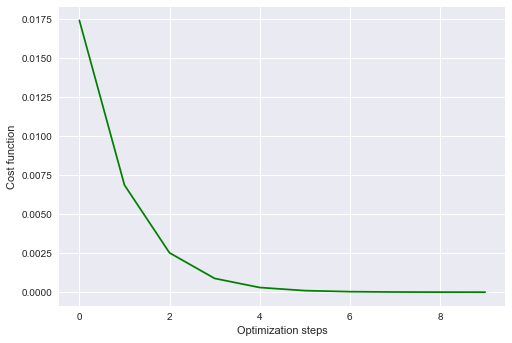

In [15]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Comparison of quantum and classical results
===========================================

Since the specific problem considered in this tutorial has a small size,
we can also solve it in a classical way and then compare the results
with our quantum solution.


Classical algorithm
===================

To solve the problem in a classical way, we use the explicit matrix
representation in terms of numerical NumPy arrays.


In [25]:
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(32)
A_1 = np.kron(np.kron(np.kron(np.kron(X, Z), Id), Id), Id)
A_2 = np.kron(np.kron(np.kron(np.kron(X, Id), Id), Id), Id)

A_num = c[0] * A_0 + c[1] * A_1 + c[2] * A_2
b = np.ones(32) / np.sqrt(32)

We can print the explicit values of $A$ and $b$:


In [26]:
#print("A = \n", A_num)
print(A_num)
print("b = \n", b)

[[0.58823529 0.         0.         ... 0.         0.         0.        ]
 [0.         0.58823529 0.         ... 0.         0.         0.        ]
 [0.         0.         0.58823529 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.58823529 0.         0.        ]
 [0.         0.         0.         ... 0.         0.58823529 0.        ]
 [0.         0.         0.         ... 0.         0.         0.58823529]]
b = 
 [0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767 0.1767767
 0.1767767 0.1767767 0.1767767 0.1767767]


The solution can be computed via a matrix inversion:


In [27]:
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

Finally, in order to compare $x$ with the quantum state $|x\rangle$, we
normalize and square its elements.


In [28]:
c_probs = (x / np.linalg.norm(x)) ** 2

Preparation of the quantum solution
===================================


Given the variational weights `w` that we have previously optimized, we
can generate the quantum state $|x\rangle$. By measuring $|x\rangle$ in
the computational basis we can estimate the probability of each basis
state.

For this task, we initialize a new PennyLane device and define the
associated QNode.


In [29]:
dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x)
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # Therefore, sampling from the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots).
    return qml.sample()

To estimate the probability distribution over the basis states we first
take `n_shots` samples and then compute the relative frequency of each
outcome.


In [30]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples, minlength=2 ** n_qubits) / n_shots

Comparison
==========

Let us print the classical result.


In [31]:
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.02306223 0.02306223 0.02306223 0.02306223 0.02306223 0.02306223
 0.02306223 0.02306223 0.03943777 0.03943777 0.03943777 0.03943777
 0.03943777 0.03943777 0.03943777 0.03943777 0.02306223 0.02306223
 0.02306223 0.02306223 0.02306223 0.02306223 0.02306223 0.02306223
 0.03943777 0.03943777 0.03943777 0.03943777 0.03943777 0.03943777
 0.03943777 0.03943777]


The previous probabilities should match the following quantum state
probabilities.


In [32]:
print("|<x|n>|^2=\n", q_probs)

|<x|n>|^2=
 [0.023098 0.023088 0.02317  0.023225 0.023218 0.023012 0.022952 0.023447
 0.039285 0.039409 0.039474 0.039242 0.039412 0.039121 0.039162 0.038928
 0.022897 0.023085 0.023147 0.023092 0.023115 0.023157 0.023498 0.023044
 0.039652 0.03968  0.039454 0.039257 0.039366 0.039333 0.039423 0.039557]


Let us graphically visualize both distributions.


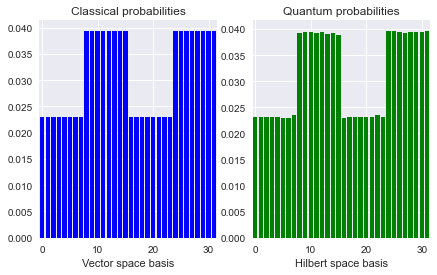

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

References
==========

1.  Carlos Bravo-Prieto, Ryan LaRose, Marco Cerezo, Yigit Subasi, Lukasz
    Cincio, Patrick J. Coles. \"Variational Quantum Linear Solver: A
    Hybrid Algorithm for Linear Systems.\"
    [arXiv:1909.05820](https://arxiv.org/abs/1909.05820), 2019.
2.  Robin Kothari. \"Efficient algorithms in quantum query complexity.\"
    PhD thesis, University of Waterloo, 2014.

About the author
================
